In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp

In [3]:
%store -r ieee13_mat_compl_ground_truth_08_23_2021
%store -r ieee123_mat_compl_perturb_08_31_2021

# Item 1. Sensitivity Matrix Completion

We observe a matrix $\mathbf{X}_0 \in \mathbb{R}^{M \times N}$ which we assume to have $\textbf{rank}(\mathbf{X}_0) = R << M,N$

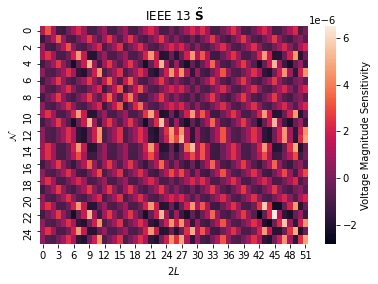

In [4]:
S_13 = ieee13_mat_compl_ground_truth_08_23_2021['S_IEEE13']
S_123 = ieee123_mat_compl_perturb_08_31_2021['S']
sns.heatmap(S_13,cbar_kws={'label':'Voltage Magnitude Sensitivity'})
plt.xlabel('$2L$')
plt.ylabel('$\mathcal{N}$')
plt.title(r"IEEE 13 $\tilde{\mathbf{S}}$")
plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/sensitivity_mat.png")

In [5]:
pwd

'/home/sam/github/PowerSensitivities.jl/notebooks'

## 1.1 Test this assumption:

Compute the truncated singular value decomposition representation using the Eckhart Young Theorem.

In [6]:
def spectral_analysis(S):
    """Computes normalized and commulative spectral analysis for a given matrix with the SVD"""
    u,sigma,vt = np.linalg.svd(S)
    sigma_total = np.sum(sigma)
    normed_sigma = sigma/sigma_total
    cum_sigma = np.cumsum(normed_sigma)
    return cum_sigma,normed_sigma

In [7]:
u,sigma,vt = np.linalg.svd(S_13)
print("Singular value vector: ",sigma.shape,sigma)

Singular value vector:  (26,) [4.41858831e-05 3.88814386e-05 1.84365903e-05 6.86546494e-06
 5.50587238e-06 2.85999983e-06 1.90708853e-06 1.85892687e-06
 1.49572390e-06 1.28127193e-06 1.18269446e-06 1.00567439e-06
 8.46469727e-07 8.15508511e-07 5.68108758e-07 4.43815107e-07
 4.08220612e-07 3.80413821e-07 3.56552725e-07 3.28873273e-07
 2.71675982e-07 2.51829259e-07 2.46379256e-07 2.04116926e-07
 1.70464206e-07 1.41225270e-07]


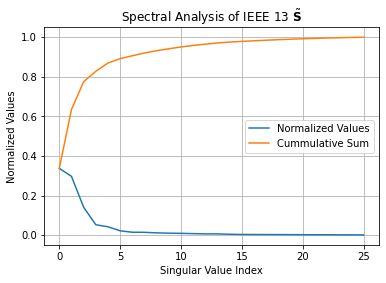

In [8]:
sigma_total = np.sum(sigma)
normed_sigma = sigma/sigma_total
cum_sigma = np.cumsum(normed_sigma)
plt.plot(normed_sigma,label="Normalized Values")
plt.plot(cum_sigma,label="Cummulative Sum")
plt.legend()
plt.xlabel("Singular Value Index")
plt.grid()
plt.ylabel("Normalized Values")
plt.title(r"Spectral Analysis of IEEE 13 $\tilde{\mathbf{S}}$")
plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spectral.png")

# Item 2: Low-Rank Matrix *Completion*
Matrix *completion* seeks to fill in an observed matrix $\mathbf{S}_0$ with unknown measurements:
$$
\min_{\mathbf{S} \in \mathbb{R}^{M \times 2L}} ||\mathbf{S} - \mathbf{S}_0||_F^2\\
\text{subject to: } \text{rank}(\mathbf{S})=R
$$

Where $||\mathbf{S} - \mathbf{S}_0||_F^2 = \sum_{m,n} (S[m,n]-S_0[m,n])^2$ is the squared Frobenius norm.

## 2.1: Linear Measurements and Spectral Analysis

In [9]:
m,n = S_13.shape
# pick which entries we observe uniformly at random
O = np.random.randint(0,2, (m, n))
# multiply A by O coordinate-wise

Y = np.multiply(S_13, O)

In [20]:
np.linalg.matrix_rank(Y)

26

In [18]:
z = 0
for row in O:
    for i in row:
        if(i == 0):
            z+=1
            
print(z)

698


In [19]:
m*n

1352

Text(0.5, 1.0, 'Observed Entries in Sensitivity Matrix')

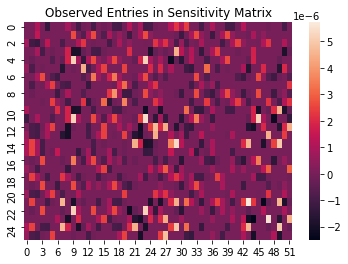

In [10]:
sns.heatmap(Y)
plt.title('Observed Entries in Sensitivity Matrix')

In [11]:
np.linalg.matrix_rank(S_13)

26

## 2.2 Nuclear Norm Minimzation and Regularization Tuning

Instead of solving the standard matrix completion program derived from the Eckhart-Young Theorem:

$$
\min_{S} ||S - S_0||_F^2 \text{Subject to: rank}(S) = R
$$

we instead solve a *convex relaxtion* of the program:
$$
\min_{S} ||S - S_0||_F^2 + \lambda ||S||_*
$$

Where $$||S||_* = \sum_k \sigma_k(S)$$ is the *nuclear norm* - or sum of the singular values - and $\lambda$ is a hyperparameter.

In [12]:
def mat_com_loss(S,S0):
    return cp.sum_squares(S0 - S)

def mat_com_obj(S,S0,lamb):
    return mat_com_loss(S,S0) + mat_com_reg(S,lamb)
        
def mat_com_reg(S,lamb):
    return lamb*cp.atoms.norm(S,"nuc")

def mse(S_hat,S_0):
    m_,n_ = S_0.shape
    m,n = S_hat.shape
    assert m_ == m
    assert n_ == n
    return np.sqrt((1/m*n)*mat_com_loss(S_hat,S_0).value)



In [13]:
S0 = Y #Observed incomplete matrix
S = cp.Variable(S0.shape) #Decision variable
lamb = cp.Parameter(nonneg=True) #Reg hyperparam
prob = cp.Problem(cp.Minimize(mat_com_obj(S,S0,lamb))) #Problem
lamb_values = np.logspace(-6,2,1000) #Lambda values

In [14]:
train_errors = []
ground_truth_errors = []
S_optimals = []
for l in lamb_values:
    lamb.value = l
    prob.solve(verbose=False)
    train_errors.append(mse(S,S0))
    ground_truth_errors.append(mse(S,S_13))
    S_optimals.append(S.value)

Failure:Interrupted


SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
sns.set_context("talk")
width = 2*3.5
height = 2*(width)/1.61828
fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(width,height),constrained_layout=True)
axes[0].plot(lamb_values, train_errors, label="Train error")
axes[0].set_xscale("log")
axes[0].set_title(r"Train Error: $RMSE(\tilde{\mathbf{S}}^*;\tilde{\mathbf{S}}_0)$ (p.u.)")
axes[0].grid()
#axes[0].ticklabel_format(useMathText=True,useOffset=False)
axes[1].set_xlabel(r"$||\tilde{\mathbf{S}}||_*$ Regularization Parameter $\lambda$")
axes[1].plot(lamb_values, np.array(ground_truth_errors), label="Ground truth error",c="orange")
axes[1].set_xscale("log")
axes[1].set_title(r"Test Error: $RMSE(\tilde{\mathbf{S}}^*;\tilde{\mathbf{S}}^{\#})$ (p.u.)")
axes[1].grid()
#axes[1].ticklabel_format(useMathText=True,useOffset=False)
#axes[1].ticklabel_format(axis='y',style='sci',use)
plt.suptitle("IEEE-13 Bus Jacobian Completion RMSE (p.u.)")
plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/rmse_cv.png")

In [119]:
print('Mean RMSE: ',np.mean(ground_truth_errors))

Mean RMSE:  8.262111498917628e-05


## 2.3 Compare Spectral Analysis

In [110]:
#Get the optimal recovered S matrix
opt_idx = np.argmin(ground_truth_errors)
Shat = S_optimals[opt_idx]
cum_sigma_gt,normed_sigma_gt = spectral_analysis(S_13)
cum_sigma,normed_sigma = spectral_analysis(Shat)


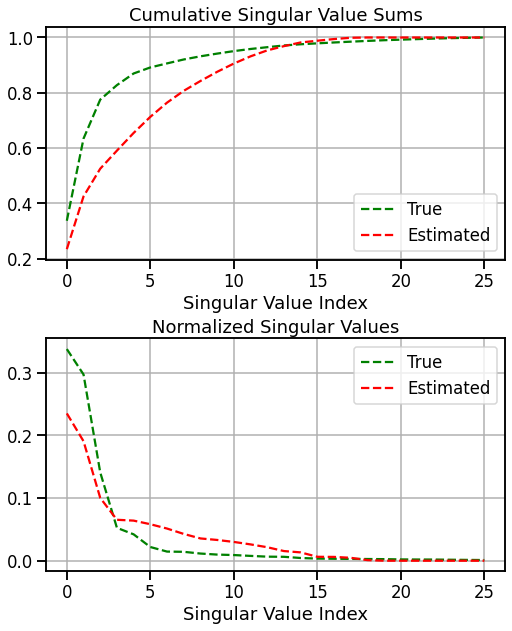

In [120]:
fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(width,height),constrained_layout=True)
axes[0].set_title("Cumulative Singular Value Sums")
axes[0].plot(cum_sigma_gt,'g--',label="True")
axes[0].plot(cum_sigma,"r--",label="Estimated")
axes[0].legend()
axes[1].set_title("Normalized Singular Values")
axes[1].plot(normed_sigma_gt,"g--",label="True")
axes[1].plot(normed_sigma,"r--",label='Estimated')
axes[1].legend()
axes[0].grid()
axes[1].grid()
axes[1].set_xlabel("Singular Value Index")
axes[0].set_xlabel("Singular Value Index")
plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spectral_analysis.png")
########################


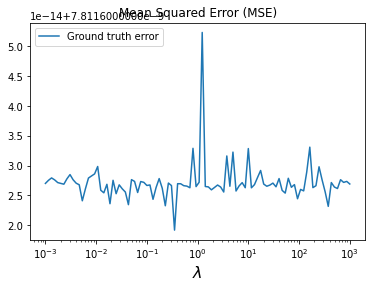

In [31]:
axes[1].plot(lamb_values, ground_truth_errors, label="Ground truth error")
axes[1].set_xscale("log")
axes[1].set_title("Perturb/Observe Error")
plt.xlabel(r"$\lambda$", fontsize=16)
plt.title("Mean Squared Error (MSE)")
plt.show()

In [24]:
def simplex_projection(s):
    """Projection onto the unit simplex."""
    if np.sum(s) <=1 and np.alltrue(s >= 0):
        return s
    # Code taken from https://gist.github.com/daien/1272551
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, len(u)+1) > (cssv - 1))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - 1) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    return np.maximum(s-theta, 0)

def nuclear_projection(A):
    """Projection onto nuclear norm ball."""
    U, s, V = np.linalg.svd(A, full_matrices=False)
    s = simplex_projection(s)
    return U.dot(np.diag(s).dot(V))


In [7]:
n, k = 1000, 10
# random rank-10 matrix normalized to have nuclear norm 1
U = np.random.normal(0, 1, (n, k))
U = np.linalg.qr(U)[0]
S = np.diag(np.random.uniform(0, 1, k))
S /= np.sum(S)
A = U.dot(S.dot(U.T))
# pick which entries we observe uniformly at random
O = np.random.randint(0,2, (n, n))
# multiply A by O coordinate-wise
Y = np.multiply(A, O)

def mc_objective(Y, O, X):
    """Matrix completion objective."""
    return 0.5 * np.linalg.norm(Y-np.multiply(X, O), 'fro')**2

def mc_gradient(Y, O, X):
    """Gradient of matrix completion objective."""
    return np.multiply(X, O) - Y

In [11]:
# start from random matrix of nuclear norm 1
X0 = np.random.normal(0,1, (n,n))
X0 = nuclear_projection(X0.dot(X0.T))
objective = lambda X: mc_objective(Y, O, X)
gradient = lambda X: mc_gradient(Y, O, X)
Xs = gradient_descent(X0, [0.2]*40, gradient, nuclear_projection)



NameError: name 'gradient_descent' is not defined

# Item 2: Low-Rank Matrix *Recovery*

Low-Rank Matrix *Recovery* is distinct from Low-Rank matrix *approximation*. 

Instead of observing an incomplete matrix $\mathbf{X}_0$, We observe a "linear measurement" 

$$
\bar{\mathbf{d}} \approx \mathcal{A}(\mathbf{X}) + \mathbf{z} \in \mathbb{R}^L
$$

Where $\mathcal{A} : \mathbb{R}^{M \times N} \mapsto \mathbb{R}^{L}$ is a "linear measurement operator"

In [27]:
import inv_model_static as inv
#Test the static IEEE13 Estimation
buses = ['633','671']
phases = ['3','3']
kws = [ '-150','-25']
kvars = ['-100','-45']
voltages = inv.multiple_injection_voltages(inv.dss,buses,phases,kws,kvars,opendssDir=opendssDir_IEEE13)
d = np.asarray(voltages) - np.asarray(voltages_basecase)
xhat,xhat_df = est.least_squares_process(S_IEEE13[:,0:16],d,injection_labels[0:16])

ModuleNotFoundError: No module named 'inv_model_static'